# Packages

Below are the packages required for this assignment, feel free to import more if needed.

In [1]:
import time
import zarr
import numpy as np
from IPython.display import IFrame
import matplotlib.pyplot as plt
import itk
import SimpleITK as sitk
import unittest
tc = unittest.TestCase()

%matplotlib inline

# 1 - Data inspection / preprocessing

## 1.1 - Load the sample data
You are given a sample CT volume and its annotation for several heart structures in the data folder:
- `sample_CT_volume.zarr.zip` contains the CT volume and the xy spacing / z spacing of this scan
- `sample_annotation.zarr.zip` contains the annotation mask and the label information
- This CT volume is of shape (256, 512, 512) corresponding to axes (z, y, x)
- The annotation is a multi-class mask where each voxel value indicates the annotated label

Load the data by running the code below.

In [2]:
# Check virtual memory, and increase docker size as necessary
import psutil
psutil.virtual_memory()

svmem(total=16789286912, available=15329394688, percent=8.7, used=713875456, free=2189692928, active=3212570624, inactive=10299629568, buffers=312020992, cached=13573697536, shared=418959360, slab=1027948544)

In [3]:
# load the data
with zarr.open('./data/sample_CT_volume.zarr.zip', mode='r') as z:
    ct_volume = z['image'][:]
    xy_spacing = z.attrs['xy_spacing']
    z_spacing = z.attrs['z_spacing']
    
with zarr.open('./data/sample_annotation.zarr', mode='r') as z:
    mask = z['mask'][:]
    classes = z.attrs['classes']

In [4]:
# explore the data
print(f'CT volume dimension: {ct_volume.shape}')
print(f'CT xy spacing: {xy_spacing}mm')
print(f'CT z spacing: {z_spacing}mm')
print('Labels:', classes)

CT volume dimension: (256, 512, 512)
CT xy spacing: 0.398438mm
CT z spacing: 0.625mm
Labels: {'0': 'background', '1': 'left ventricular volume', '2': 'left ventricular wall', '3': 'right ventricular volume', '4': 'right atrial volume', '5': 'left atrial volume'}


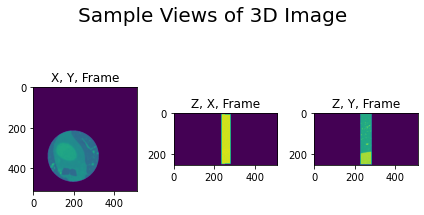

In [5]:
# Sample of image for context
f, (ax1, ax2, ax3) = plt.subplots(1,3)

ax1.set_title('X, Y, Frame')
ax1.imshow(ct_volume[0, :, :])
ax2.set_title('Z, X, Frame')
ax2.imshow(ct_volume[:,1,:])
ax3.set_title('Z, Y, Frame')
ax3.imshow(ct_volume[:,:,1])

f.suptitle('Sample Views of 3D Image', fontsize=20)

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=1)
plt.show()

In [6]:
# logo = sitk.ReadImage(ct_volume)
# image = sitk.Image(256, 512, 512, sitk.sitkFloat64)
img_3D = sitk.GetImageFromArray(ct_volume)
# In LTK order is x,y,z. While in numpy, an array is indexed in the opposite order (z,y,x).
img_3D.GetSize()

(512, 512, 256)

In [7]:
# Quick View Of Original Image Stats
img_3D.SetSpacing([0.398438,0.398438,0.625])
original_spacing = img_3D.GetSpacing()
print(original_spacing)
print(img_3D.GetDimension())
print(img_3D.GetOrigin())
print(img_3D.GetSize())
print(img_3D.GetOrigin())
print(img_3D.GetPixel(0, 0, 0))

(0.398438, 0.398438, 0.625)
3
(0.0, 0.0, 0.0)
(512, 512, 256)
(0.0, 0.0, 0.0)
-3024.0


<img src='./vis/image_and_annotation.png'>
<caption><center>One sample slice and its annotation in the axial view</center></caption>

## 1.2 - Image resizing
Since the CT scan usually comes in anisotropic dimension with different spacings, it's sometimes required to resize them into isotropic volume for further steps. 
- The first task you are asked to do is to resize the given CT volume into an isotropic one with 1mm spacing
- Resize the annotation mask as well into an isotropic volume with 1mm spacing
- Please complete the functions in the cell below, you can call any function from any librarie and feel free to add helper functions as you see fit
- Run and time the functions to resize the volumes

In [8]:
# RESIZING FUNCTIONS
def resize_ct_volume(ct_volume, xy_spacing, z_spacing, out_xy_spacing=1, out_z_spacing=1, interpolator = sitk.sitkLinear):
    """
    Arguments:
    ct_volume -- the 3D image of a CT scan
    xy_spacing -- original xy spacing of the scan
    z_spacing -- original z spacing of the scan
    out_xy_spacing -- xy spacing of the target volume
    out_z_spacing -- z spacing of the target volume
    
    Returns:
    new_volume -- the target volume 
    """
    # read image
    image = sitk.GetImageFromArray(ct_volume)
    image.SetSpacing([xy_spacing,xy_spacing,z_spacing])
    original_spacing = image.GetSpacing() # [512, 512, 256]
    
    # Image is already isotropic, just return a copy.
    if all(spc == original_spacing[0] for spc in original_spacing):
        return sitk.Image(image)
    # Make image isotropic via resampling.
    original_size = image.GetSize()
    print("original_spacing", original_spacing)
    print("original_size", original_size)  
    
    spacing = out_xy_spacing
    if spacing is None:
        spacing = min(original_spacing)
    new_spacing = [spacing]*image.GetDimension()
    print("new spacing", new_spacing)
    
    new_size = [int(round(osz*ospc/spacing)) for osz,ospc in zip(original_size, original_spacing)]
    print("new size", new_size)
    
    return sitk.Resample(image, new_size, sitk.Transform(), interpolator,
                         image.GetOrigin(), new_spacing, image.GetDirection(), 0,
                         image.GetPixelID())

In [9]:
%%time
new_image = resize_ct_volume(ct_volume, xy_spacing=0.398438, z_spacing=0.625, out_xy_spacing=1, out_z_spacing=1)
# Would typically use logging instead of print here
print("Confirm new spacing", new_image.GetSpacing())
print("Confirm new size", new_image.GetSize())
tc.assertEqual((1,1,1), new_image.GetSpacing())

original_spacing (0.398438, 0.398438, 0.625)
original_size (512, 512, 256)
new spacing [1, 1, 1]
new size [204, 204, 160]
Confirm new spacing (1.0, 1.0, 1.0)
Confirm new size (204, 204, 160)
CPU times: user 4.84 s, sys: 8.59 s, total: 13.4 s
Wall time: 11.3 s


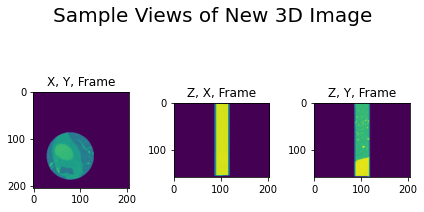

CPU times: user 625 ms, sys: 156 ms, total: 780 ms
Wall time: 500 ms


In [10]:
%%time
# Test print sample image to make sure its intact
numpy_new_image = sitk.GetArrayViewFromImage(new_image)
# Sample of image for context
f, (ax1, ax2, ax3) = plt.subplots(1,3)

ax1.set_title('X, Y, Frame')
ax1.imshow(numpy_new_image[0, :, :])
ax2.set_title('Z, X, Frame')
ax2.imshow(numpy_new_image[:,1,:])
ax3.set_title('Z, Y, Frame')
ax3.imshow(numpy_new_image[:,:,1])

f.suptitle('Sample Views of New 3D Image', fontsize=20)

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=1)
plt.show()

In [11]:
print(mask.shape)
print(np.unique(mask))

(256, 512, 512)
[0. 1. 2. 3. 4. 5.]


In [12]:
def resize_annotation(mask, xy_spacing, z_spacing, out_xy_spacing=1, out_z_spacing=1):
    """
    Arguments:
    mask -- the 3D multi-class annotation mask of a CT scan
    xy_spacing -- original xy spacing of the mask
    z_spacing -- original z spacing of the mask
    out_xy_spacing -- xy spacing of the target mask
    out_z_spacing -- z spacing of the target mask
    
    Returns:
    new_mask -- the target mask
    """
    
    ### Main difference here is using interpolator=sitkNearestNieghbors instead of Linear Interpolator 
    return resize_ct_volume(mask, xy_spacing, z_spacing, out_xy_spacing=1, out_z_spacing=1, interpolator=sitk.sitkNearestNeighbor)

In [13]:
%%time
new_mask = resize_annotation(mask, xy_spacing=0.398438, z_spacing=0.625)
new_mask_array = sitk.GetArrayViewFromImage(new_mask)
print("Checking consistent categories", np.unique(new_mask_array))
tc.assertCountEqual([0.0, 1.0, 2.0, 3.0, 4.0, 5.0], np.unique(new_mask_array))

original_spacing (0.398438, 0.398438, 0.625)
original_size (512, 512, 256)
new spacing [1, 1, 1]
new size [204, 204, 160]
Checking consistent categories [0. 1. 2. 3. 4. 5.]
CPU times: user 1.08 s, sys: 249 ms, total: 1.33 s
Wall time: 1.14 s


CPU times: user 39.8 ms, sys: 15.3 ms, total: 55.1 ms
Wall time: 45.8 ms


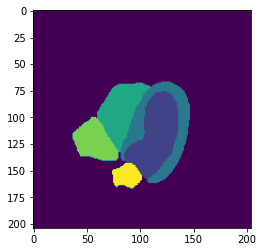

In [14]:
%%time
# Test Image Constructed Correclty
plt.imshow(new_mask_array[100, :, :])

<img src='./vis/original_vs_isotropic.png'>
<caption><center>The original image and the resized result of one sample slice in the sagittal view</center></caption>

## 1.3 - 3D visualization
Now you have the resized ct volume and the annotation mask, could you come up with any way(s) to inspect the data in 3D?
- Run the cell below to see an example generated with Plotly in which the contour points on each slice are plotted for each annotated structure
- Note that since the origin lies at the bottom in this visualization, the mask has been reversed in z axis so that the heart doesn't look upside down
- You can either visualize the ct volume or the annotation mask, or both. You can also replicate the example provided

In [15]:
IFrame(src='./vis/3D_vis.html', width=700, height=600)

In [16]:
# Plotly Example uses
X, Y, Z = np.mgrid[-8:8:40j, -8:8:40j, -8:8:40j]
values = np.sin(X*Y*Z) / (X*Y*Z)
print(len(X.flatten()))
print(len(values.flatten()))

64000
64000


In [17]:
import numpy as np
import scipy
import skimage
from skimage import draw

coord = np.argwhere(numpy_new_image) # or use .nonzero()
x = coord[:,0]
y = coord[:,1]
z = coord[:,2]
mask_values = new_mask_array.flatten()
print(len(x))
print(len(mask_values))

6658560
6658560


In [18]:
# Check virtual memory again
import psutil
psutil.virtual_memory()

svmem(total=16789286912, available=13342932992, percent=20.5, used=2687713280, free=1044897792, active=3239727104, inactive=11437309952, buffers=312156160, cached=12744519680, shared=418963456, slab=1007329280)

In [19]:
import plotly.graph_objects as go

# Note: This is not rendering on my local. 

# fig = go.Figure(data=go.Volume(
#     x=x,
#     y=y,
#     z=z,
#     value=mask_values,
#     isomin=0.1,
#     isomax=0.8,
#     opacity=0.1, # needs to be small to see through all surfaces
#     surface_count=17, # needs to be a large number for good volume rendering
#     ))
# fig.show()

In [20]:
# Note: 
# I was looking at the VTK project, I think this would be an optimal solution for this but it is more complex. 
# https://github.com/Kitware/VTK

# 2 - Sum kernel
Suppose we have a 2D image and would apply a simple kernel ***REPEATEDLY*** with ***DIFFERENT SIZES*** on it to take the sum of all pixels within the kernel. Write a function to efficiently calculate the sum. The image below shows an example image and kernels with different sizes in different colors.
- The kernel will be defined by its upper left `(row1, col1)` and lower right corner `(row2, col2)`
- Please complete the function in the cell below and add some test cases
- Discuss the time and space complexity for the approach you take

***Example:***
```python
image = np.array([[1, 2, 3], 
                  [4, 5, 6], 
                  [7, 8, 9]])

query_image = Image(image)
kernel_sum = query_image.calculate(0, 1, 1, 2) # kernel_sum = 2 + 3 + 5 + 6 = 16
```

<img src='./vis/sum_grid.jpeg'>

In [21]:
# SUM KERNEL

class Image:
    
    def __init__(self, image):
        self.image = image

    def calculate_kernel_sum(self, row1, col1, row2, col2):
        
        if any([row1 >= row2, col1 >= col2, 
                row2 > self.image.shape[0], 
                col2 > self.image.shape[1]]):
            raise ValueError("Requires r1<r2 & c1<c2 & Indexes In Bounds")
        print(self.image[row1:row2+1, col1:col2+1])
        return np.sum(self.image[row1:row2+1, col1:col2+1])

In [22]:
image_1 = np.array([[1, 2, 3], 
                  [4, 5, 6], 
                  [7, 8, 9]])

query_image = Image(image_1)
kernel_sum = query_image.calculate_kernel_sum(0, 1, 1, 2)
print(kernel_sum)
tc.assertEqual(kernel_sum, 16)

[[2 3]
 [5 6]]
16


In [23]:
image_2 = np.array([[3, 0, 1, 4, 2], 
                  [5, 6, 3, 2, 1], 
                  [1, 2, 0, 1, 5],
                 [4, 1, 0, 1, 7],
                 [1, 0, 3, 0, 5]])
query_image = Image(image_2)

# Test Green Square
kernel_sum = query_image.calculate_kernel_sum(1, 1, 2, 2)
print("Green Square", kernel_sum)
tc.assertEqual(kernel_sum, 11)

# Test Blue Square
kernel_sum = query_image.calculate_kernel_sum(1, 2, 2, 4)
print("Blue Square", kernel_sum)
tc.assertEqual(kernel_sum, 12)


# Test Red Square
kernel_sum = query_image.calculate_kernel_sum(2, 1, 5, 3)
print("Red Square", kernel_sum)
tc.assertEqual(kernel_sum, 8)

[[6 3]
 [2 0]]
Green Square 11
[[3 2 1]
 [0 1 5]]
Blue Square 12
[[2 0 1]
 [1 0 1]
 [0 3 0]]
Red Square 8


### Time complexity discussion

Almost all calculations in numpy are O(n) or linear for a given dimension. 
So considering we are initializing a 2D array, slicing the 2D array, and getting the sum of the 2D array using numpy functions only.
The time complexity for each step would be O(i * j).